In [1]:
# General
import os
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16, 7)  # make the default figure size larger
matplotlib.rcParams['image.interpolation'] = 'nearest'  # don't blur/smooth image plots

# PSF - STAR direct
import webbpsf
import webbpsf.roman

# Gaussian - GALAXY direct
from astropy.modeling.functional_models import Gaussian2D as gauss

# pysynphot - work with spectra
import pysynphot as S

# Astropy - read files
from astropy.io import fits
from astropy.table import Table

# Grizli - sim
from grizli.model import GrismFLT

# Progress bar
from tqdm import tqdm
from IPython.display import clear_output

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits/")

/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


In [2]:
# Name all relevant files & load in catalog
direct_file = "ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits"
empty_seg = "empty_seg.fits"
empty_direct = "empty_direct.fits"

hlss_tbl = Table.read("/Users/keith/astr/research_astr/FOV0/catalogs/MOT_SCA1_roll_0_dither_0x_0y_cut_zcut.txt",
                      format="ascii")
hlss_tbl = hlss_tbl.group_by("MODIMAGE")
hlss_tbl.groups[0].sort("MAG_F1500W", reverse=True)
hlss_tbl.groups[1].sort("MAG_F1500W", reverse=True)

# # While testing and imporving sim, I'm only using a small cutout
# x_pos = 2124
# y_pos = 1223
# size = 500
# cutout_condition = (abs(hlss_tbl["X_IMAGE"] - x_pos) < size) & (abs(hlss_tbl["Y_IMAGE"] - y_pos) < size)
# cutout_tbl = hlss_tbl[np.where(cutout_condition)]

# cutout_tbl = cutout_tbl.group_by("MODIMAGE")

In [3]:
# Generate and Save an empty segmentation fits and direct fits
zero_data = np.zeros((4088,4088))

# Take header info from prepared direct image
file = fits.open(direct_file)
phdu = file[0]
hdr = file[1].header

# Structure empty direct fits
ihdu = fits.ImageHDU(data=zero_data, header=hdr, name="SCI")
errhdu = fits.ImageHDU(data=zero_data, header=hdr, name="ERR")
dqhdu = fits.ImageHDU(data=zero_data, header=hdr, name="DQ")
hdul = [phdu, ihdu, errhdu, dqhdu]

# Save both files
fits.HDUList(hdul).writeto(empty_direct, overwrite=True)
fits.writeto(empty_seg, data=zero_data, header=hdr, overwrite=True)

# I/O and cleaning
file.close()
del phdu
del hdr
del ihdu
del errhdu
del dqhdu
del hdul

# No longer deleting zero_data variable; used to save zero ERR and DQ FITS extensions later

In [4]:
# Semi-function amplitude and mag-normed count functions
f158_lam_center = 1.577 * 10**-6 # meter
telarea = 2.36**2 * constants.pi # meter ** 2

# theoretically, this is comparable to an ABZeropoint
f_0 = 3.7059108273831045e-10 # this is just a number that seems to get close to expected values in testing

# Calculate number of counts as a function of magnitude
N = lambda mag: telarea * (f158_lam_center / (constants.h * constants.speed_of_light)) * f_0 * 10**(-0.4 * mag)

# Calculate 2D Gassian amplitude as a function of galaxy shape and magnitude
amplitude_func = lambda x_stddev, y_stddev, mag: N(mag) / (2 * constants.pi * x_stddev * y_stddev)

In [5]:
# Instantiate Grizli
pad = 100
roman_sim = GrismFLT(direct_file=empty_direct, seg_file=empty_seg, pad=pad)

# Instantiate WebbPSF
wfi = webbpsf.roman.WFI()
wfi.filter = "GRISM0"

# Instantiate empty segmentation map and direct image; for troubleshooting
# This will be filled with every iteration so you can see at the end what Grizli had to work with
full_seg = np.zeros((4088, 4088))
full_direct = np.zeros((4088, 4088))



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
empty_direct.fits / Pad ref HDU with 264 pixels
empty_direct.fits / blot segmentation empty_seg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [6]:
# Define SED directory
SED_dir = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs"

# G0V Spectrum source file
src = webbpsf.specFromSpectralType('G0V', catalog='phoenix')
wave = np.linspace(10000,20000,10000) # Angstroms
flux = src(wave).value
star_spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstrom", fluxunits="flam")
del wave
del flux

# Create Bandpass object
df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

error_file = open("super_errors.txt", "a+")

for object in tqdm(hlss_tbl):

    # DIRECT SIMULATION --------------------------

    # Take object info
    id = object["NUMBER"]
    mag = object["MAG_F1500W"]
    x_0 = object["X_IMAGE"]
    y_0 = object["Y_IMAGE"]
    modimage = object["MODIMAGE"]

    # STAR
    if modimage:
        x_0 = round(x_0)
        y_0 = round(y_0)
        # Produce PSF Image at detector position
        wfi.detector_position = (x_0 + 4, y_0 + 4) # WebbPSF include 4 rows of dark pixels
        psf = wfi.calc_psf(normalize='last', fov_pixels=182, oversample=2, source=src)

        # Multiply PSF by magnitude-normalized photon count
        total_photon_count = N(mag)
        psf[0].data *= total_photon_count

        # Place PSF in direct image
        dir_array = np.zeros((4088,4088)) # empty array

        det_xmin = max(0, x_0 - 182)       # Where is the PSF on the detector; limit by detector bounds
        det_xmax = min(4088, x_0 + 182)
        det_ymin = max(0, y_0 - 182)
        det_ymax = min(4088, y_0 + 182)

        psf_xmin = max(0, 182 - x_0)        # Take only the PSF on the detector
        psf_xmax = min(364, 182 + 4088 - x_0)
        psf_ymin = max(0, 182 - y_0)
        psf_ymax = min(364, 182 + 4088 - y_0)

        dir_array[det_ymin:det_ymax, det_xmin:det_xmax] = psf[0].data[psf_ymin:psf_ymax, psf_xmin:psf_xmax]
        roman_sim.direct.data["SCI"] = np.rot90(dir_array, k=3).astype("float32")
        full_direct += np.rot90(dir_array, k=3).astype("float32")

    # GALAXY
    else:
        x_mean = y_0 # x and y are flipped in Gaussian2D function
        y_mean = x_0 # x and y are flipped in Gaussian2D function
        x_stddev = object["B_IMAGE"] # Semi-minor is x-axis per testing
        y_stddev = object["A_IMAGE"] # Semi-major is y-axis per testing
        theta = object["THETA_IMAGE"].value * (constants.pi / 180) # Counterclockwise rotation; radians

        # Calculate 2D Gaussian amplitude/max value
        amplitude = amplitude_func(x_stddev, y_stddev, mag)
        args = (amplitude, x_mean, y_mean, x_stddev, y_stddev, theta) # store args for readability

        # Create direct object image
        dir_array = np.fromfunction(lambda i,j: gauss.evaluate(i, j, *args), shape=(4088,4088))

        # Store temp_direct; Rotated for dispersion in right direction
        roman_sim.direct.data["SCI"] = np.rot90(dir_array, k=3).astype("float32")
        full_direct += np.rot90(dir_array, k=3).astype("float32")

    # SEGMENTATION -------------------------------

    # Empty temp_seg every time
    temp_seg = np.zeros((4088,4088), dtype="float32")
    
    # Anywhere temp_direct isn't zero is our object; NOTE: DIRECT IMAGE ALREADY ROTATED; DO NOT ROTATE AGAIN HERE
    # Using slice method for stars to speed up slightly
    if modimage:
        condition = (roman_sim.direct.data["SCI"][det_ymin:det_ymax, det_xmin:det_xmax] != 0)
        temp_seg[det_ymin:det_ymax, det_xmin:det_xmax][np.where(condition)] = id
    else:
        condition = (roman_sim.direct.data["SCI"] != 0)
        temp_seg[np.where(condition)] = id 

    # Write objects too small to land on seg in seperate file
    if not np.any(temp_seg):
        error_file.write("ID {0} not in temp_seg \n".format(id))
        continue

    # Store temp_seg
    roman_sim.seg = temp_seg
    full_seg += temp_seg

    # GRISM SIMULATION ---------------------------

    # STAR
    if modimage:
        # Renorm STAR spectrum with bandpass and magnitude, convert back to cgs units
        spec = star_spec.renorm(mag, "abmag", bp)
        spec.convert("flam")

    # GALAXY
    else:
        # Load GALAXY SED
        sed_path = os.path.join(SED_dir, "SED:rest:gal.{0}.fits".format(object["SPECTEMP"]))
        spectrum = Table.read(sed_path, format="fits")
        wave = spectrum["wavelength"]
        flux = spectrum["flux"]
        z = object['Z']

        # Create Spectrum object, redshift, normalize with bandpass, convert back to cgs units
        spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstrom", fluxunits="flam").redshift(z)
        spec = spec.renorm(mag, "abmag", bp)
        spec.convert("flam")

    roman_sim.compute_model_orders(id, mag=mag, compute_size=False, size=77, 
                                   in_place=True, store=False, spectrum_1d=[spec.wave, spec.flux], is_cgs=True)

  1%|▏         | 138/10763 [00:34<42:31,  4.16it/s]

ID 136415 not found in segmentation image


  2%|▏         | 238/10763 [00:57<40:24,  4.34it/s]

ID 74258 not found in segmentation image


  2%|▏         | 241/10763 [00:58<41:01,  4.28it/s]

ID 65012 not found in segmentation image


  2%|▏         | 244/10763 [00:58<41:07,  4.26it/s]

ID 94017 not found in segmentation image


  3%|▎         | 270/10763 [01:05<42:39,  4.10it/s]

ID 104592 not found in segmentation image


  3%|▎         | 316/10763 [01:16<41:56,  4.15it/s]

ID 147220 not found in segmentation image


  4%|▎         | 403/10763 [01:37<41:36,  4.15it/s]

ID 40815 not found in segmentation image


  4%|▍         | 413/10763 [01:39<42:07,  4.09it/s]

ID 63865 not found in segmentation image


  5%|▍         | 508/10763 [02:03<42:13,  4.05it/s]

ID 68195 not found in segmentation image


  5%|▍         | 534/10763 [02:09<41:43,  4.09it/s]

ID 19068 not found in segmentation image


  6%|▌         | 649/10763 [02:37<40:39,  4.15it/s]

ID 855 not found in segmentation image


  8%|▊         | 813/10763 [03:19<42:19,  3.92it/s]

ID 60547 not found in segmentation image


  9%|▉         | 1002/10763 [04:07<43:42,  3.72it/s]

ID 154952 not found in segmentation image


 10%|▉         | 1065/10763 [04:25<45:00,  3.59it/s]

ID 74424 not found in segmentation image


 10%|▉         | 1076/10763 [04:28<43:41,  3.70it/s]

ID 101642 not found in segmentation image


 10%|█         | 1120/10763 [04:39<43:09,  3.72it/s]

ID 64248 not found in segmentation image


 11%|█         | 1190/10763 [04:59<43:19,  3.68it/s]

ID 187390 not found in segmentation image


 12%|█▏        | 1264/10763 [05:19<42:49,  3.70it/s]

ID 155974 not found in segmentation image


 12%|█▏        | 1343/10763 [05:40<42:23,  3.70it/s]

ID 194116 not found in segmentation image


 13%|█▎        | 1379/10763 [05:50<42:08,  3.71it/s]

ID 170524 not found in segmentation image


 13%|█▎        | 1387/10763 [05:52<41:34,  3.76it/s]

ID 136420 not found in segmentation image


 14%|█▍        | 1480/10763 [06:17<41:55,  3.69it/s]

ID 40762 not found in segmentation image


 14%|█▍        | 1531/10763 [06:31<42:35,  3.61it/s]

ID 124920 not found in segmentation image


 14%|█▍        | 1537/10763 [06:33<42:04,  3.65it/s]

ID 4 not found in segmentation image


 16%|█▌        | 1715/10763 [07:21<39:50,  3.79it/s]

ID 114057 not found in segmentation image


 16%|█▌        | 1737/10763 [07:27<39:53,  3.77it/s]

ID 55810 not found in segmentation image


 16%|█▋        | 1765/10763 [07:34<40:23,  3.71it/s]

ID 117933 not found in segmentation image


 18%|█▊        | 1939/10763 [08:21<39:43,  3.70it/s]

ID 22851 not found in segmentation image


 18%|█▊        | 1943/10763 [08:22<40:21,  3.64it/s]

ID 136421 not found in segmentation image


 20%|██        | 2164/10763 [09:23<38:41,  3.70it/s]

ID 147230 not found in segmentation image


 20%|██        | 2203/10763 [09:33<38:12,  3.73it/s]

ID 128514 not found in segmentation image


 21%|██        | 2219/10763 [09:38<38:05,  3.74it/s]

ID 36577 not found in segmentation image


 21%|██▏       | 2291/10763 [09:57<37:54,  3.72it/s]

ID 165064 not found in segmentation image


 21%|██▏       | 2306/10763 [10:01<38:39,  3.65it/s]

ID 902 not found in segmentation image


 22%|██▏       | 2336/10763 [10:09<37:34,  3.74it/s]

ID 153878 not found in segmentation image


 22%|██▏       | 2393/10763 [10:25<37:48,  3.69it/s]

ID 118984 not found in segmentation image


 24%|██▎       | 2535/10763 [11:03<36:25,  3.77it/s]

ID 1443 not found in segmentation image


 25%|██▍       | 2640/10763 [11:32<35:44,  3.79it/s]

ID 115539 not found in segmentation image


 25%|██▍       | 2643/10763 [11:33<36:00,  3.76it/s]

ID 20614 not found in segmentation image


 25%|██▌       | 2698/10763 [11:47<35:51,  3.75it/s]

ID 102979 not found in segmentation image


 26%|██▌       | 2748/10763 [12:00<33:15,  4.02it/s]

ID 11658 not found in segmentation image


 27%|██▋       | 2946/10763 [12:52<33:56,  3.84it/s]

ID 143055 not found in segmentation image


 28%|██▊       | 3011/10763 [13:09<35:21,  3.65it/s]

ID 41786 not found in segmentation image


 29%|██▉       | 3111/10763 [13:36<34:55,  3.65it/s]

ID 120042 not found in segmentation image


 29%|██▉       | 3113/10763 [13:37<34:38,  3.68it/s]

ID 96886 not found in segmentation image


 29%|██▉       | 3171/10763 [13:52<34:26,  3.67it/s]

ID 19735 not found in segmentation image


 30%|███       | 3271/10763 [14:19<34:11,  3.65it/s]

ID 75977 not found in segmentation image


 31%|███▏      | 3372/10763 [14:47<31:59,  3.85it/s]

ID 187609 not found in segmentation image


 33%|███▎      | 3542/10763 [15:31<32:46,  3.67it/s]

ID 102075 not found in segmentation image


 33%|███▎      | 3549/10763 [15:33<31:49,  3.78it/s]

ID 59380 not found in segmentation image


 35%|███▍      | 3715/10763 [16:18<31:12,  3.76it/s]

ID 147658 not found in segmentation image


 36%|███▌      | 3833/10763 [16:48<29:21,  3.93it/s]

ID 174379 not found in segmentation image


 37%|███▋      | 3989/10763 [17:29<31:09,  3.62it/s]

ID 80484 not found in segmentation image


 37%|███▋      | 4011/10763 [17:35<29:43,  3.79it/s]

ID 116417 not found in segmentation image


 38%|███▊      | 4103/10763 [17:59<28:08,  3.94it/s]

ID 96254 not found in segmentation image


 39%|███▉      | 4231/10763 [18:31<27:29,  3.96it/s]

ID 194299 not found in segmentation image


 40%|████      | 4356/10763 [19:03<27:26,  3.89it/s]

ID 115677 not found in segmentation image


 41%|████      | 4427/10763 [19:20<26:39,  3.96it/s]

ID 138019 not found in segmentation image


 42%|████▏     | 4561/10763 [19:55<26:23,  3.92it/s]

ID 96740 not found in segmentation image


 42%|████▏     | 4574/10763 [19:58<26:01,  3.96it/s]

ID 68097 not found in segmentation image


 45%|████▍     | 4804/10763 [20:56<25:06,  3.95it/s]

ID 173798 not found in segmentation image


 45%|████▍     | 4835/10763 [21:04<24:46,  3.99it/s]

ID 139278 not found in segmentation image


 47%|████▋     | 5006/10763 [21:47<24:05,  3.98it/s]

ID 180464 not found in segmentation image


 47%|████▋     | 5009/10763 [21:48<24:10,  3.97it/s]

ID 68087 not found in segmentation image


 47%|████▋     | 5045/10763 [21:57<24:38,  3.87it/s]

ID 112640 not found in segmentation image


 47%|████▋     | 5089/10763 [22:08<23:45,  3.98it/s]

ID 189658 not found in segmentation image


 47%|████▋     | 5101/10763 [22:11<24:00,  3.93it/s]

ID 117592 not found in segmentation image


 50%|████▉     | 5346/10763 [23:13<22:53,  3.94it/s]

ID 83457 not found in segmentation image


 51%|█████     | 5457/10763 [23:42<22:10,  3.99it/s]

ID 39776 not found in segmentation image


 52%|█████▏    | 5543/10763 [24:03<22:05,  3.94it/s]

ID 69480 not found in segmentation image


 52%|█████▏    | 5554/10763 [24:06<21:42,  4.00it/s]

ID 12140 not found in segmentation image


 53%|█████▎    | 5678/10763 [24:37<21:11,  4.00it/s]

ID 166527 not found in segmentation image


 54%|█████▎    | 5785/10763 [25:05<20:33,  4.03it/s]

ID 190832 not found in segmentation image


 54%|█████▍    | 5790/10763 [25:06<20:46,  3.99it/s]

ID 548 not found in segmentation image


 54%|█████▍    | 5851/10763 [25:21<21:04,  3.89it/s]

ID 155142 not found in segmentation image


 61%|██████    | 6530/10763 [28:15<18:07,  3.89it/s]

ID 114388 not found in segmentation image


 62%|██████▏   | 6675/10763 [28:52<17:18,  3.94it/s]

ID 143077 not found in segmentation image


 62%|██████▏   | 6716/10763 [29:03<16:55,  3.98it/s]

ID 180657 not found in segmentation image


 64%|██████▍   | 6878/10763 [29:44<16:28,  3.93it/s]

ID 103017 not found in segmentation image


 67%|██████▋   | 7179/10763 [31:00<15:12,  3.93it/s]

ID 156744 not found in segmentation image


 68%|██████▊   | 7314/10763 [31:34<14:28,  3.97it/s]

ID 96885 not found in segmentation image


 68%|██████▊   | 7320/10763 [31:36<14:31,  3.95it/s]

ID 195034 not found in segmentation image


 69%|██████▉   | 7418/10763 [32:01<14:26,  3.86it/s]

ID 178686 not found in segmentation image


 70%|██████▉   | 7522/10763 [32:27<13:30,  4.00it/s]

ID 79259 not found in segmentation image


 71%|███████   | 7628/10763 [32:54<13:25,  3.89it/s]

ID 83534 not found in segmentation image


 72%|███████▏  | 7790/10763 [33:35<12:38,  3.92it/s]

ID 63062 not found in segmentation image


 73%|███████▎  | 7865/10763 [33:54<12:11,  3.96it/s]

ID 169422 not found in segmentation image


 74%|███████▍  | 7995/10763 [34:27<11:59,  3.85it/s]

ID 68086 not found in segmentation image


 77%|███████▋  | 8240/10763 [35:30<10:40,  3.94it/s]

ID 172146 not found in segmentation image


 77%|███████▋  | 8250/10763 [35:32<10:41,  3.92it/s]

ID 68088 not found in segmentation image


 77%|███████▋  | 8334/10763 [35:53<10:06,  4.00it/s]

ID 18396 not found in segmentation image


 80%|███████▉  | 8581/10763 [36:56<09:17,  3.91it/s]

ID 129233 not found in segmentation image


 80%|████████  | 8632/10763 [37:09<09:06,  3.90it/s]

ID 102085 not found in segmentation image


 82%|████████▏ | 8857/10763 [38:06<07:57,  3.99it/s]

ID 61981 not found in segmentation image


 83%|████████▎ | 8882/10763 [38:12<07:58,  3.93it/s]

ID 59775 not found in segmentation image


 83%|████████▎ | 8889/10763 [38:14<07:58,  3.92it/s]

ID 147222 not found in segmentation image


 84%|████████▍ | 9021/10763 [38:48<07:32,  3.85it/s]

ID 69477 not found in segmentation image


 84%|████████▍ | 9064/10763 [39:00<07:23,  3.83it/s]

ID 180465 not found in segmentation image


 85%|████████▍ | 9099/10763 [39:09<07:01,  3.95it/s]

ID 169423 not found in segmentation image


 85%|████████▍ | 9134/10763 [39:18<06:48,  3.99it/s]

ID 147234 not found in segmentation image


 85%|████████▌ | 9161/10763 [39:24<06:41,  3.99it/s]

ID 102957 not found in segmentation image


 86%|████████▌ | 9218/10763 [39:39<06:26,  4.00it/s]

ID 134473 not found in segmentation image


 86%|████████▌ | 9264/10763 [39:50<06:22,  3.92it/s]

ID 102094 not found in segmentation image


 87%|████████▋ | 9383/10763 [40:21<05:52,  3.92it/s]

ID 177782 not found in segmentation image


 87%|████████▋ | 9406/10763 [40:27<05:40,  3.98it/s]

ID 147223 not found in segmentation image


 88%|████████▊ | 9449/10763 [40:38<05:33,  3.93it/s]

ID 59885 not found in segmentation image


 88%|████████▊ | 9486/10763 [40:47<05:20,  3.98it/s]

ID 102978 not found in segmentation image


 89%|████████▉ | 9614/10763 [41:19<04:53,  3.92it/s]

ID 62056 not found in segmentation image


 89%|████████▉ | 9629/10763 [41:23<04:48,  3.93it/s]

ID 137936 not found in segmentation image


 91%|█████████ | 9747/10763 [41:54<04:20,  3.90it/s]

ID 32922 not found in segmentation image


 91%|█████████ | 9791/10763 [42:05<04:10,  3.87it/s]

ID 10877 not found in segmentation image


 92%|█████████▏| 9856/10763 [42:22<03:48,  3.98it/s]

ID 102072 not found in segmentation image


 93%|█████████▎| 10030/10763 [43:07<03:09,  3.87it/s]

ID 116799 not found in segmentation image


 94%|█████████▍| 10136/10763 [43:35<02:48,  3.73it/s]Attempted to get aberrations at field point (3304, 3898) which is outside the range of the reference data; approximating to nearest interpolated point (3303.6532440346145, 3548.730053865441)
Attempted to get aberrations at field point (3304, 3898) which is outside the range of the reference data; approximating to nearest interpolated point (3303.6532440346145, 3548.730053865441)
Attempted to get aberrations at field point (3304, 3898) which is outside the range of the reference data; approximating to nearest interpolated point (3303.6532440346145, 3548.730053865441)
Attempted to get aberrations at field point (3304, 3898) which is outside the range of the reference data; approximating to nearest interpolated point (3303.6532440346145, 3548.730053865441)
Attempted to get aberrations at field point (3304, 3898) which is outside the range of the reference data; approximating to nearest interpolated point (3303.6532440346145, 3548.730053

In [7]:
print(f"min: {full_direct.min()}", f"max: {full_direct.max()}", f"median: {np.median(full_direct)}", sep='\n')

min: 0.0
max: 11676.91407198196
median: 0.0001297233783361662


In [8]:
sim_min = roman_sim.model.min()
sim_max = roman_sim.model.max()
sim_median = np.median(roman_sim.model[723:1723, 1624:2624])

print(f"min: {sim_min}", f"max: {sim_max}", f"median: {sim_median}", sep='\n')

min: 0.0
max: 8.80014419555664
median: 0.01570104993879795


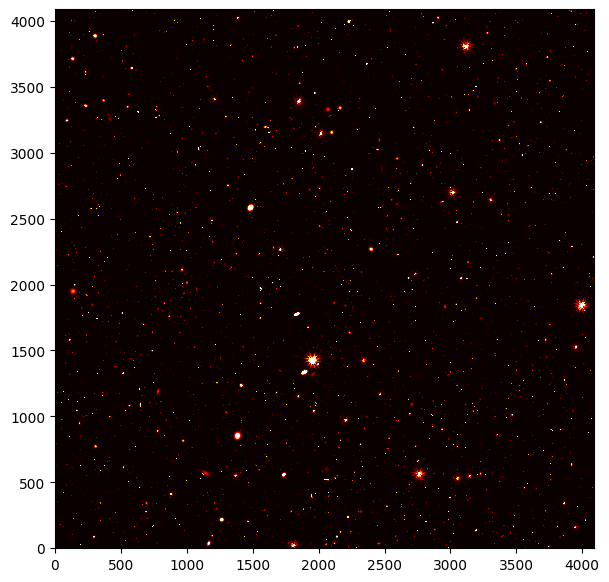

In [9]:
plt.imshow(np.rot90(full_direct), origin="lower", cmap="hot", vmin=0, vmax=5)

Text(0.5, 1.0, 'Grism Image')

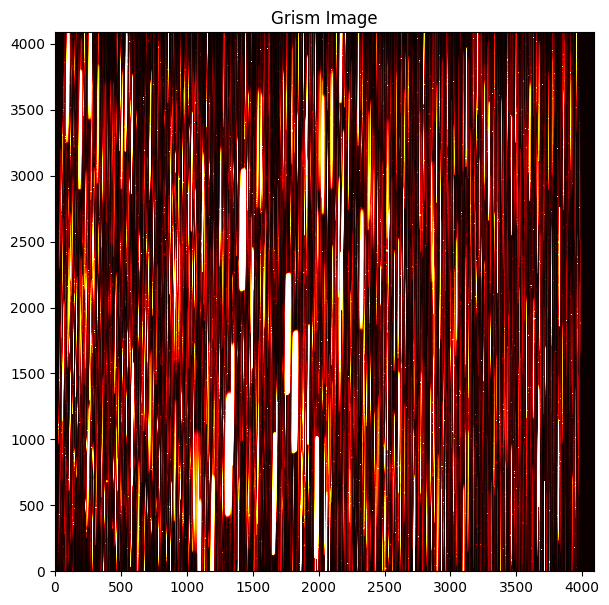

In [10]:
fig, ax = plt.subplots()

upright_img = np.rot90(roman_sim.model[pad:-pad,pad:-pad])
ax.imshow(upright_img, origin='lower', vmin=0, vmax=0.11738539732765789, cmap='hot')
ax.set_title("Grism Image")

# ax.axvline(1624)
# ax.axvline(2624)
# ax.axhline(723)
# ax.axhline(1723)

In [12]:
# Take header info from prepared direct image
file = fits.open(direct_file)
phdu = file[0]
hdr = file[1].header

# Preprare Direct FITS
dir_ihdu = fits.ImageHDU(data=np.rot90(full_direct), header=hdr, name="SCI")
dir_errhdu = fits.ImageHDU(data=zero_data, header=hdr, name="ERR")
dir_dqhdu = fits.ImageHDU(data=zero_data, header=hdr, name="DQ")
direct_hdul = [phdu, dir_ihdu, dir_errhdu, dir_dqhdu]

# Prepare Slitless FITS
slitless_ihdu = fits.ImageHDU(data=upright_img, header=hdr, name="SCI")
slitless_errhdu = fits.ImageHDU(data=zero_data, header=hdr, name="ERR")
slitless_dqhdu = fits.ImageHDU(data=zero_data, header=hdr, name="DQ")
slitless_hdul = [phdu, slitless_ihdu, slitless_errhdu, slitless_dqhdu]

# Save both files
fits.HDUList(direct_hdul).writeto("direct_sim.fits", overwrite=True)
# fits.HDUList(slitless_hdul).writeto("slitless_sim.fits", overwrite=True)

file.close()